In [3]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2024-04-09 00:52:59.958681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 00:53:00.914641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Helper Functions

#Reads data from .xyz and .ener files and stores them in Pandas Dataframe
def read_data(pathC,pathE):
    df  = pd.DataFrame(columns =['x1','y1','z1','x2','y2','z2','x3','y3','z3'])
    c = []

    with open(pathC) as f:
        for line in f:
            if(line[0]=='H' or line[0]=='O'):
                cords=(line.split())
                c.append(float(cords[1]))
                c.append(float(cords[2]))
                c.append(float(cords[3]))
                
                if(len(c)==9):              
                    df.loc[len(df.index)] = c
                    c=[]

    with open(pathE) as f:
        for line in f:
            c.append(float(line.strip()))
    df.insert(9,"energy",c)

    return df

#Returns distance between 2 points in cartesian plane
def get_dist(x1,y1,z1,x2,y2,z2):
    return np.sqrt( (x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2 )

#Normalizes Data in a Dataframe using Max and Min Values
def normalize_data(df):
    return df.iloc[:,0:].apply(lambda x: (x-x.mean())/(x.max() - x.min()), axis=0)

#Converts Co Ordinate data into Distance Data
def preprocess_data(df):
    df2 = pd.DataFrame(columns=['OH1','OH2','HH'])
    for molecule in df.iterrows():
        atoms = molecule[1]
        oh1 = get_dist(atoms.x1,atoms.y1,atoms.z1,atoms.x2,atoms.y2,atoms.z2)
        oh2 = get_dist(atoms.x3,atoms.y3,atoms.z3,atoms.x2,atoms.y2,atoms.z2)
        hh  = get_dist(atoms.x1,atoms.y1,atoms.z1,atoms.x3,atoms.y3,atoms.z3)
        df2.loc[len(df2.index)] = [oh1,oh2,hh]
    df2.insert(3,"energy",df.energy)

    return df2

In [4]:
#Read data from the files

h2o_unrotated = read_data("./data/H2O_unrotated.xyz","./data/H2O_unrotated.ener")
h2o_test = read_data("./data/H2O_test.xyz","./data/H2O_test.ener")
h2o_rotated = read_data("./data/H2O_rotated.xyz","./data/H2O_rotated.ener")

In [5]:
#View distribution of Data
h2o_rotated.describe()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,energy
count,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000
mean,0.254273,0.140451,0.120025,0.214996,0.280351,0.225502,0.078098,0.125235,0.202120,-76.376522
std,5.638545,5.671937,5.668902,5.650367,5.652361,5.651572,5.718155,5.692253,5.661974,0.003653
min,-10.693631,-10.506496,-10.393386,-10.060697,-10.125863,-10.235891,-10.638510,-10.671854,-10.317953,-76.380752
25%,-4.414594,-4.437316,-4.600717,-4.426472,-4.423391,-4.357949,-4.647912,-4.656413,-4.539722,-76.379181
50%,0.340002,0.212041,0.198453,0.318543,0.337848,0.337980,0.199021,0.089593,0.251248,-76.377624
75%,5.193472,4.959406,4.986227,5.172096,5.242135,5.166992,5.010558,5.023500,5.137699,-76.375009
max,10.527868,10.598302,10.375763,10.185401,10.260749,10.293548,10.604322,10.707676,10.238004,-76.354093


In [6]:
#Calculate distances from the given raw data
h2o_distances = preprocess_data(h2o_unrotated)
h2o_distances_test = preprocess_data(h2o_test)
h2o_rot_distances = preprocess_data(h2o_rotated)

In [8]:
#Check if data is processed properly
h2o_rot_distances.head()

,OH1,OH2,HH,energy
0,1.010110,0.921727,1.575566,-76.376448
1,0.879404,1.013385,1.541574,-76.369670
2,0.988207,0.916030,1.519479,-76.377519
3,0.907936,0.908788,1.509746,-76.372594
4,0.910070,0.997601,1.486468,-76.376294


In [10]:
#Normalize data to transform data to similiar scale
inp_data = normalize_data(h2o_distances)
tst_data = normalize_data(h2o_distances_test)
rot_data = normalize_data(h2o_rot_distances)


#If we are training on both rotated and unrotated data uncomment this line
# inp_data = pd.concat([inp_data,rot_data])

In [11]:
#View normalized data
inp_data.head()

,OH1,OH2,HH,energy
0,0.242479,-0.158877,0.175529,0.002782
1,-0.314049,0.295358,0.020140,0.257017
2,0.149220,-0.187111,-0.080862,-0.037407
3,-0.192564,-0.223001,-0.125355,0.147334
4,-0.183481,0.217136,-0.231769,0.008526


In [12]:
#Run this line to reset keras between model creation and clear variables.
keras.backend.clear_session()

In [13]:
#Return Keras Model of size [Input]->32->16->8->[Output]
def get_model(shape):
    model = keras.Sequential()

    model.add( keras.layers.Input(shape=(shape,)))
    # model.add( keras.layers.Input(shape=(shape,)))

    model.add( keras.layers.Dense(
        32,
        activation='sigmoid',
        kernel_regularizer=keras.regularizers.l2(1e-6),
        bias_regularizer=keras.regularizers.l2(1e-6)
    ))
    model.add( keras.layers.Dense(
        16,
        activation='sigmoid',
        kernel_regularizer=keras.regularizers.l2(1e-6),
        bias_regularizer=keras.regularizers.l2(1e-6)
    ))
    model.add( keras.layers.Dense(
        8,
        activation='sigmoid',
        kernel_regularizer=keras.regularizers.l2(1e-6),
        bias_regularizer=keras.regularizers.l2(1e-6)
    ))
    model.add( keras.layers.Dense(
        1,
        kernel_regularizer=keras.regularizers.l2(1e-6),
        use_bias=False
    ))

    model.compile(optimizer=keras.optimizers.Adam(0.001),loss='mse')
    # print(model.summary())
    return model

In [27]:
#Train the Model on various dataset sizes for 300 epochs
history = []

for i in range(250,2000,250):
    train, val = train_test_split(inp_data[0:i], test_size=0.2,random_state=8123)
    model = get_model(3)
    print(f'Input Data size : {i}')
    history.append(model.fit(train.iloc[:,0:-1],train.iloc[:,-1:],validation_data=(val.iloc[:,0:-1],val.iloc[:,-1:]),epochs=300))

Input Data size : 250
Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5221 - val_loss: 0.3693
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3422 - val_loss: 0.2252
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2047 - val_loss: 0.1292
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1123 - val_loss: 0.0719
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0594 - val_loss: 0.0426
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0338 - val_loss: 0.0301
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207 - val_loss: 0.0262
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0161 - val_loss: 0.0259
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170 - val_loss: 0.0262
Epoch 10/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0150 - val_loss: 0.0264
Epoch 11/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 - val_loss: 0.0263
Epoch 12/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.01

In [14]:
#Plot Loss v Epochs curves for various dataset sizes
for i in range(len(history)):
    plt.plot(history[i].history['loss'],label=f"{(i+1)*250}")
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(title="Dataset Size")

NameError: name 'history' is not defined

In [15]:
#Prepare Test Data for Prediction
test_energies = tst_data.iloc[:,-1:]
test_cords = tst_data.iloc[:,0:-1]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


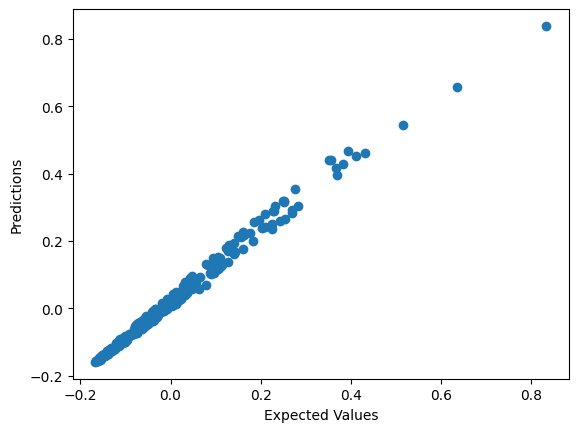

0.027225575764357506


In [53]:
#Predict Test Data
predictions = model.predict(test_cords)

#Calculate RMSE Error for Predicted Data
rmse = np.sqrt(np.mean((predictions-test_energies)**2))

#Visualize Predicted vs Expected Data Graph
plt.scatter(test_energies, predictions)
plt.xlabel('Expected Values')
plt.ylabel('Predictions')
plt.show()

print(rmse)